# Example: FaultDetector Usage
Shows how to use the `FaultDetector` class and plot the results. This includes:
1. Data Loading
2. Data format preparation
3. Training and prediction
4. Plotting
5. Evaluation of results
6. Root cause analysis using ARCANA

Get the dataset which is used in this notebook here: [CARE to Compare dataset](https://doi.org/10.5281/zenodo.14958989)

In [1]:
from energy_fault_detector import Config, FaultDetector
from energy_fault_detector.evaluation import Care2CompareDataset, CAREScore
from energy_fault_detector.utils.visualisation import plot_learning_curve, plot_score_with_threshold, plot_reconstruction

# Loading the data
We load a CARE2Compare dataset using the `Care2CompareDataset` class.

This dataset contains SCADA time series of wind turbines across three wind parks. The time series contain a training and a test/prediction dataset. The prediction data contains an 'event'. This can be an anomaly - data points were we expect anomalies to be detected, leading to a fault - or a 'normal event', an example normal behaviour. In this example, we load the data of a specific event to show how to use the `EnergyFaultDetector` for early fault detection.  

In [2]:
# Specify the path to the data
data_path = './Care_To_Compare_v6/CARE_To_Compare'

c2c = Care2CompareDataset(path=data_path)

In [3]:
# event selection
event_id = 44
event_info = c2c.get_event_info(event_id=event_id)
event_info

asset_id                                                            44
event_id                                                            44
event_label                                                    anomaly
event_start                                        2023-08-03 14:00:00
event_start_id                                                   52704
event_end                                          2023-10-08 02:20:00
event_end_id                                                     62138
event_description    Valve in water cooling system was left in wron...
wind_farm                                                            C
Name: 15, dtype: object

The data is loaded, prepared and split into train and test data. 

In [4]:
# load and split data into numerical sensor data and status_data
train_sensor_data, train_status, test_sensor_data, test_status = c2c.load_and_format_event_dataset(event_id=event_id, index_column='time_stamp')

train_sensor_data.shape, train_status.shape, test_sensor_data.shape, test_status.shape

((52560, 238), (52560,), (10443, 238), (10443,))

In [5]:
train_sensor_data.head()

,"ABB-LS Input K1, IL1 (avg)",Generator acceleration (avg),ABB-LS Active Power (avg),Active power aeration motor A (avg),Active power aeration motor B (avg),Active power grid side converter (avg),Active power HV grid (avg),Ambient temperature (avg),Generator angle speed (avg),Battery charge 1 (avg),...,Cooling water temp. generator inlet 1 (avg),Cooling water temp. generator inlet 2 (avg),Water flow (avg),Water pressure 1 cooling system (avg),Water pressure 2 cooling system (avg),Cooling water temp. generator outlet 1 (avg),Cooling water temp. generator outlet 2 (avg),Wind speed 1+2 (avg),Wind speed 1 (avg),Wind speed 2 (avg)
time_stamp,,,,,,,,,,,,,,,,,,,,,
2022-08-02 14:00:00,22.026,0.0044,0.25692,17.747,36.773,0.25032,0.25032,32.500,127.67,0.0998,...,40.384,40.279,522.02,2.496,2.496,43.922,44.026,6.710,6.607,6.813
2022-08-02 14:10:00,21.170,-0.0125,0.24716,30.407,28.820,0.24058,0.24058,32.509,126.09,0.1000,...,39.617,39.511,521.41,2.504,2.503,44.213,44.295,6.517,6.416,6.618
2022-08-02 14:20:00,18.990,0.0117,0.22202,22.764,27.175,0.21610,0.21610,32.561,121.66,0.0998,...,40.260,40.143,519.69,2.514,2.514,44.526,44.608,6.387,6.174,6.600
2022-08-02 14:30:00,18.048,-0.0098,0.21084,17.738,27.126,0.20514,0.20514,32.600,119.82,0.0998,...,40.883,40.769,521.47,2.643,2.645,45.196,45.281,6.076,5.925,6.227
2022-08-02 14:40:00,19.077,0.0056,0.22294,17.695,27.089,0.21706,0.21706,32.600,121.99,0.1000,...,42.591,42.475,521.33,4.007,4.011,44.617,44.718,6.526,6.443,6.608


The status data contains a simple boolean value, indicating whether the status of the wind turbine was normal, i.e. whether we expect normal behaviour at that timestamp. This is used later as a filter, so we can train our normal behaviour on data representing normal behaviour only.  

In [6]:
train_status.head()

time_stamp
2022-08-02 14:00:00    True
2022-08-02 14:10:00    True
2022-08-02 14:20:00    True
2022-08-02 14:30:00    True
2022-08-02 14:40:00    True
Name: status_type_id, dtype: bool

# Train the model and evaluate on the data

Now we can create an EnergyFaultDetector model. First, we create a configuration based on a `yaml` file, that says which parameters to used for data preprocessing, the autoencoder architecture, scoring anf thresholding. A full commented example of configuration options is found in the [docs](https://aefdi.github.io/EnergyFaultDetector/usage_examples.html#configuration).

Next, we create a `FaultDetector` instance with this configuration and fit the model. The `fit` method returns a `ModelMetadata` object, containing the `model_path`, if the model was saved, the `model_date` (when training finished) and the reconstruction errors of the autoencoder for both training and validation data.

In [7]:
# The EnergyFaultDetector needs a configuration - here we load a specific configuration for this dataset...
config = Config(config_filename='c2c_configs/windfarm_C.yaml')
# ...and update features to exclude (counters) and angles for data preprocessing
c2c.update_c2c_config(config=config, wind_farm='C')

model = FaultDetector(config=config)
train_results = model.fit(sensor_data=train_sensor_data, normal_index=train_status, save_models=False)

# save the model manually if needed by using
# model.save_models(model_name='my_model') or set save_models=True (default value)

2025-10-14 07:41:40,114 - energy_fault_detector - INFO - Initialize models..
2025-10-14 07:41:41,085 - energy_fault_detector - INFO - Fit preprocessor pipeline.
2025-10-14 07:41:42,695 - energy_fault_detector - INFO - Train autoencoder.
2025-10-14 07:42:09,489 - energy_fault_detector - INFO - Fit threshold.
2025-10-14 07:42:09,537 - energy_fault_detector - INFO - Best F_0.5 score: 0.977, threshold: 4.21


In [8]:
train_results.model_date, train_results.model_path

('20251014_074209', None)

The `FaultDetector.predict` method returns a `FaultDetectionResult` object containing several result dataframes.

In [9]:
predictions = model.predict(sensor_data=test_sensor_data)

predictions.reconstruction.head()

# recon_error: reconstruction error of the autoencoder
# reconstruction: reconstruction of the input data (rescaled to original scale)
# predicted_anomalies: dataframe with column indicating whether an anomaly is detected
# anomaly_score: dataframe with column containing the Anomaly Score
# bias_data: dataframe with ARCANA bias vector, if root cause analysis was performed
# arcana_losses: dataframe containing recorded ARCANA losses
# tracked_bias: List of recorded biases during ARCANA iterations


,"ABB-LS Input K1, IL1 (avg)",Generator acceleration (avg),ABB-LS Active Power (avg),Active power aeration motor A (avg),Active power aeration motor B (avg),Active power grid side converter (avg),Active power HV grid (avg),Ambient temperature (avg),Generator angle speed (avg),Battery charge 1 (avg),...,Cooling water temp. generator inlet 1 (avg),Cooling water temp. generator inlet 2 (avg),Water flow (avg),Water pressure 1 cooling system (avg),Water pressure 2 cooling system (avg),Cooling water temp. generator outlet 1 (avg),Cooling water temp. generator outlet 2 (avg),Wind speed 1+2 (avg),Wind speed 1 (avg),Wind speed 2 (avg)
time_stamp,,,,,,,,,,,,,,,,,,,,,
2023-08-02 14:00:00,3.706654,-0.011962,0.006598,17.258429,29.674700,0.026084,-0.014535,31.277607,7.962271,0.020382,...,33.738499,34.128033,505.134430,1.482348,1.329140,40.198082,40.327957,6.278439,6.876895,6.431639
2023-08-02 14:10:00,4.233015,-0.014103,0.015873,28.102039,22.896000,0.023129,-0.002766,31.237375,2.782055,0.015646,...,32.576157,32.835583,509.461792,1.433644,1.305376,39.375092,39.405807,6.809670,7.232272,6.919015
2023-08-02 14:20:00,3.580819,-0.014908,0.003709,17.536919,27.738289,0.030171,-0.019669,31.360575,7.634915,0.024250,...,33.156067,33.606998,504.369324,1.475417,1.307740,39.669388,39.819443,6.624452,7.327813,6.754477
2023-08-02 14:30:00,3.495498,-0.014503,-0.001517,25.523815,27.016748,0.019964,-0.023871,31.078094,4.566718,0.012762,...,31.932920,32.777061,503.837708,1.454423,1.274531,39.042072,39.120319,7.766054,8.618772,7.973859
2023-08-02 14:40:00,3.983913,-0.013513,0.005579,22.445700,27.074856,0.029456,-0.019273,30.859770,9.831339,0.023365,...,32.836761,33.566765,502.166412,1.492074,1.316893,39.600258,39.771137,6.767014,7.553390,6.961023


In [10]:
predictions.predicted_anomalies.head()

,anomaly
time_stamp,
2023-08-02 14:00:00,True
2023-08-02 14:10:00,True
2023-08-02 14:20:00,True
2023-08-02 14:30:00,True
2023-08-02 14:40:00,True


# Plot the evaluation results
1. Model training loss
2. Plotting the anomaly score including model threshold
3. Adding anomaly markers in the anomaly score plot

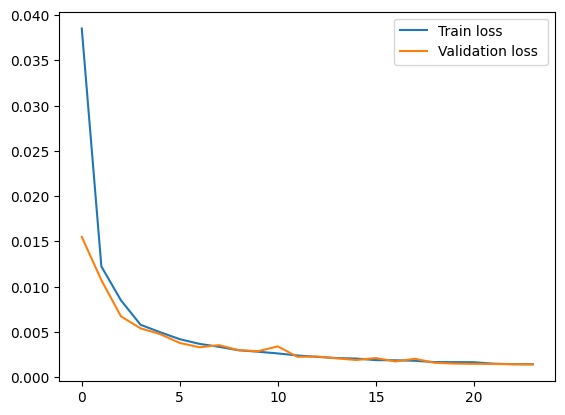

In [11]:
fig, ax = plot_learning_curve(model)

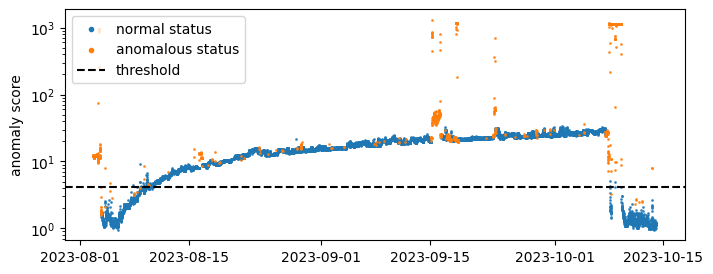

In [12]:
fig, ax = plot_score_with_threshold(model=model, data=test_sensor_data, normal_index=test_status)
ax.set_yscale('log')

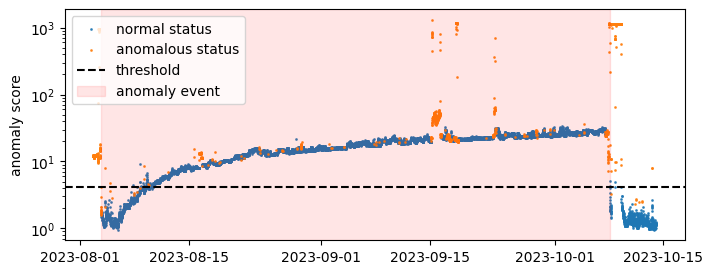

In [13]:
# Add the anomaly event
fig, ax = plot_score_with_threshold(model=model, data=test_sensor_data, normal_index=test_status)
ax.set_yscale('log')
ax.axvspan(event_info['event_start'], event_info['event_end'], alpha=0.1, color='red', label='anomaly event')
ax.legend(loc='upper left')

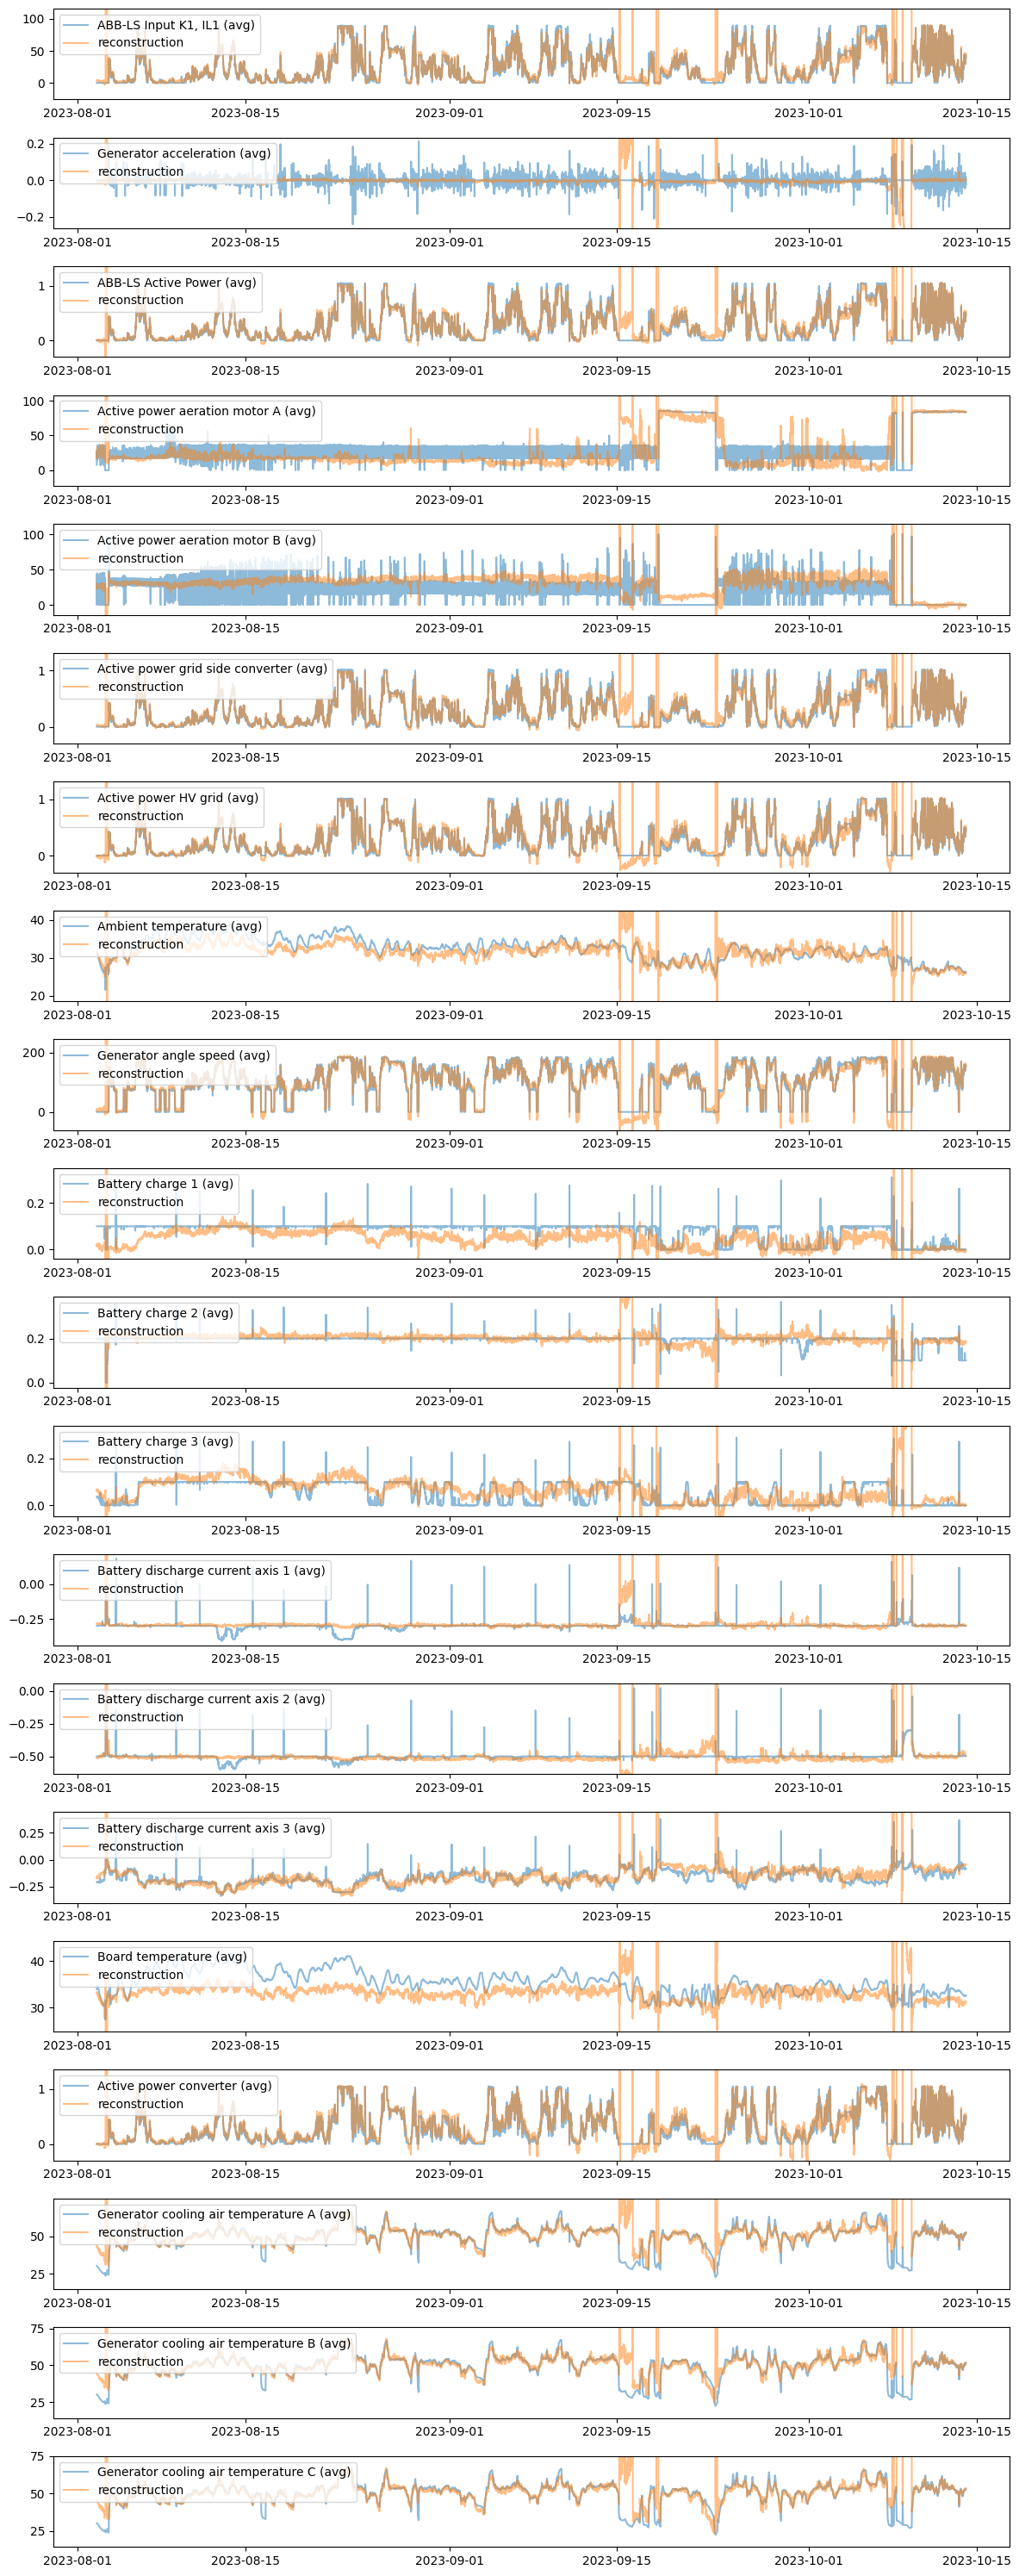

In [14]:
# Plot reconstruction of the first couple of features
fig, ax = plot_reconstruction(test_sensor_data, predictions.reconstruction, features_to_plot=predictions.reconstruction.columns[:20])

In this dataset the sensor measurement for 'Water conductivity QIT1' was drifting. How to find this feature is shown below. 

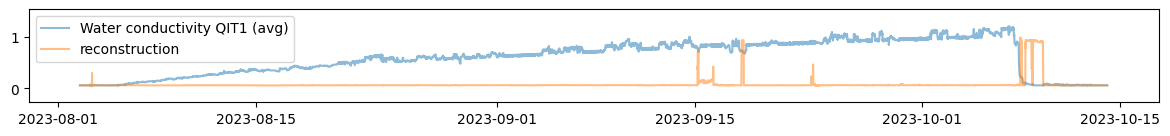

In [15]:
# Plot the feature with the anomalous behaviour
fig, ax = plot_reconstruction(test_sensor_data, predictions.reconstruction, features_to_plot=['Water conductivity QIT1 (avg)'])

## Evaluate results

This section showcases two examples for result evaluation:
1. Evaluating the given prediction and ground truth with the Fbeta Score
2. Plotting the Confusion matrix

In [16]:
from sklearn.metrics import fbeta_score, confusion_matrix, ConfusionMatrixDisplay

In [17]:
# create boolean series with the ground truth for this dataset
ground_truth = CAREScore.create_ground_truth(
    event_start=event_info['event_start'],
    event_end=event_info['event_end'],
    event_label=event_info['event_label'],
    normal_index=test_status
)

predicted_anomalies = predictions.predicted_anomalies['anomaly']

fbeta_score(y_true=ground_truth, y_pred=predicted_anomalies, beta=1)

0.9533140593211265

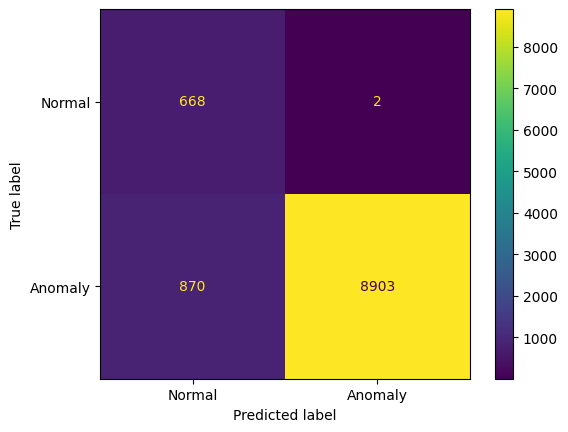

In [18]:
disp = ConfusionMatrixDisplay(confusion_matrix(ground_truth, predicted_anomalies, labels=[False, True]),
                              display_labels=["Normal", "Anomaly"],)
disp.plot()

# Root Cause Analysis with Arcana
To find the features that caused the EnergyFaultDetector to detect an anomaly, we use `ARCANA`, a feature attribution method for autoencoder models. For more details on ARCANA, we refer to the [paper](https://doi.org/10.1016/j.egyai.2021.100065).

Since it only makes sense to use ARCANA on data points that were detected as anomalies, we first find the anomaly events of, in this case, at least 20 timestamps long (to reduce the number of short anomalies that may not be significant). Then we apply ARCANA on the longest anomaly event detected to find the features that lead the model to detect anomalous behaviour.
 

In [19]:
from energy_fault_detector.utils.analysis import create_events

# Find anomaly events
event_meta_data, event_data_list = create_events(sensor_data=test_sensor_data, boolean_information=predicted_anomalies, min_event_length=20)
event_meta_data

,start,end,duration
0,2023-08-02 14:00:00,2023-08-03 13:50:00,0 days 23:50:00
1,2023-08-09 11:40:00,2023-08-09 15:10:00,0 days 03:30:00
2,2023-08-10 07:00:00,2023-10-08 02:30:00,58 days 19:30:00
3,2023-10-08 07:00:00,2023-10-08 19:30:00,0 days 12:30:00
4,2023-10-08 19:50:00,2023-10-09 14:00:00,0 days 18:10:00


Since our configuration did not contain parameters for ARCANA, we add them here. This is fully optional, we can also run the root cause analysis with default parameters.

In [20]:
# Specify Arcana parameters in the config
rca_config_dict = model.config.config_dict
rca_config_dict['root_cause_analysis'] = {
    'alpha': 0.5,  # weighting for the loss combination in Arcana. 0.5 means equal weighting between reconstruction and regularization
   'init_x_bias': 'recon',  # initialization method of x_bias. 'recon' means starting with the reconstruction error
   'num_iter': 1000,  # number of iterations for gradient based optimization of x_bias. Visualize the convergence behavior with the loss plots from next section to identify the optimal number of iterations.
   'max_sample_threshold': 10000,  # Maximum number of samples which are analyzed by ARCANA. This parameter is usually set to 1000, but for visualisation purposes we set it higher in this example. A lower value will speed up calculations.
   'verbose': True  # logs loss every 50th iteration
}
model.config.update_config(new_config_dict=rca_config_dict)

In [21]:
# Analyze the longest event - this can take a while, depending on the number of samples analyzed (max_sample_threshold) and iterations (num_iter)
longest_event_index = event_meta_data[event_meta_data['duration'] == event_meta_data['duration'].max()].index[0]
event_data = event_data_list[longest_event_index]
arcana_bias, arcana_losses, tracked_bias = model.run_root_cause_analysis(sensor_data=event_data, track_losses=True, track_bias=True)

2025-10-14 07:42:15,329 - energy_fault_detector - INFO - 0 Combined Loss: 0.62
2025-10-14 07:42:19,709 - energy_fault_detector - INFO - 50 Combined Loss: 0.59
2025-10-14 07:42:23,665 - energy_fault_detector - INFO - 100 Combined Loss: 0.55
2025-10-14 07:42:27,594 - energy_fault_detector - INFO - 150 Combined Loss: 0.53
2025-10-14 07:42:31,667 - energy_fault_detector - INFO - 200 Combined Loss: 0.50
2025-10-14 07:42:35,709 - energy_fault_detector - INFO - 250 Combined Loss: 0.48
2025-10-14 07:42:40,761 - energy_fault_detector - INFO - 300 Combined Loss: 0.46
2025-10-14 07:42:45,902 - energy_fault_detector - INFO - 350 Combined Loss: 0.44
2025-10-14 07:42:50,884 - energy_fault_detector - INFO - 400 Combined Loss: 0.42
2025-10-14 07:42:55,949 - energy_fault_detector - INFO - 450 Combined Loss: 0.41
2025-10-14 07:43:00,970 - energy_fault_detector - INFO - 500 Combined Loss: 0.39
2025-10-14 07:43:06,034 - energy_fault_detector - INFO - 550 Combined Loss: 0.38
2025-10-14 07:43:11,155 - energ

Finally, we calculate the ARCANA-bias vector, which represents the feature attributions. We find that sensor_225, Water conductivity QIT1, is the one with the highest attribution to the detected anomaly.

In [22]:
from energy_fault_detector.root_cause_analysis.arcana_utils import calculate_mean_arcana_importances

# compute ARCANA importances from the ARCANA bias
importances = calculate_mean_arcana_importances(bias_data=arcana_bias)
importances.sort_values(ascending=False)

Water conductivity QIT1 (avg)                 0.933221
Rotor bearing flow rate (avg)                 0.006413
Current water cooler pump 1 (avg)             0.005920
Hydraulic pressure locking memory  (avg)      0.004179
Current water cooler pump 2 (avg)             0.003507
                                                ...   
RMS line to line current axis 3 (avg)         0.000052
Axis 1 cooling element temperature (avg)      0.000051
Ambient temperature (avg)                     0.000050
Pollution indicator gearbox filter C (avg)    0.000050
Generator acceleration (avg)                  0.000049
Length: 243, dtype: float32

The Arcana-bias represents a regularized estimate for the difference between the input sensor data and a version of the input which has a low reconstruction error.
Intuitively this means that the bias represents the difference between the input data and a normal version of the input data according to the used autoencoder model.
Feature-Importances can be derived from the Arcana-bias and they give an indication of which input features contributed the most to reconstruction errors. Thus, they represent the data features which caused anomalous behavior according to the used autoencoder model.

## Primary visualisation of root cause analysis results

The shown visualizations in this section are useful for working with ARCANA for root cause analysis

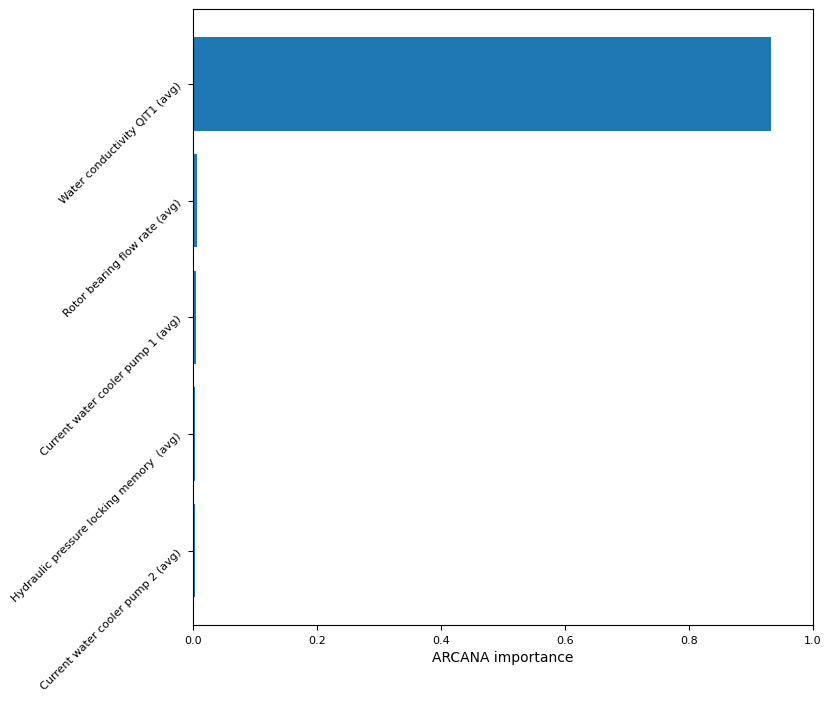

In [23]:
from energy_fault_detector.utils.visualisation import plot_arcana_mean_importances

_ = plot_arcana_mean_importances(importances=importances, top_n_features=5)

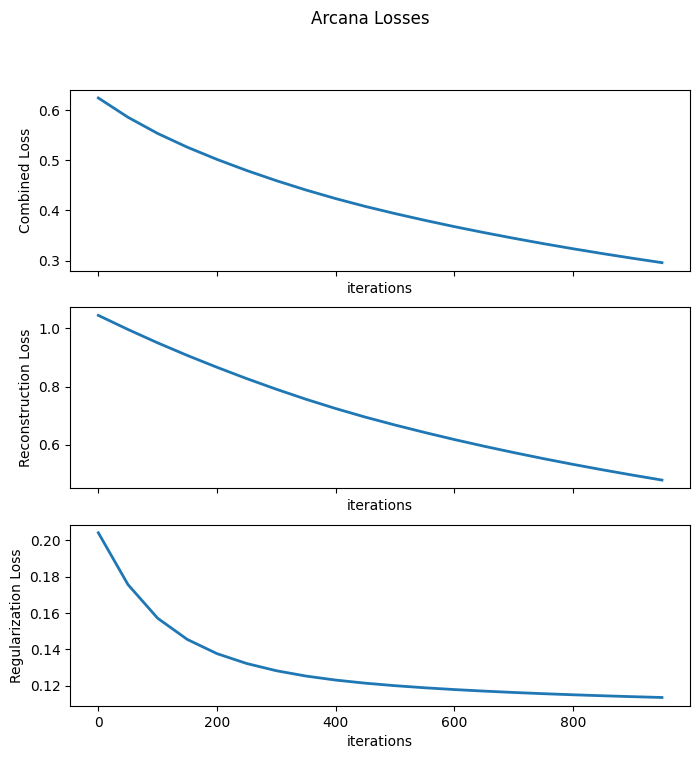

In [24]:
from energy_fault_detector.utils.visualisation import plot_arcana_losses

plot_arcana_losses(losses=arcana_losses)

## Secondary visualisation of root cause analysis results

Secondary visualisations are mainly useful for analyzing the way in which ARCANA calculates the final bias and feature importances.

2025-10-14 07:43:52,556 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>


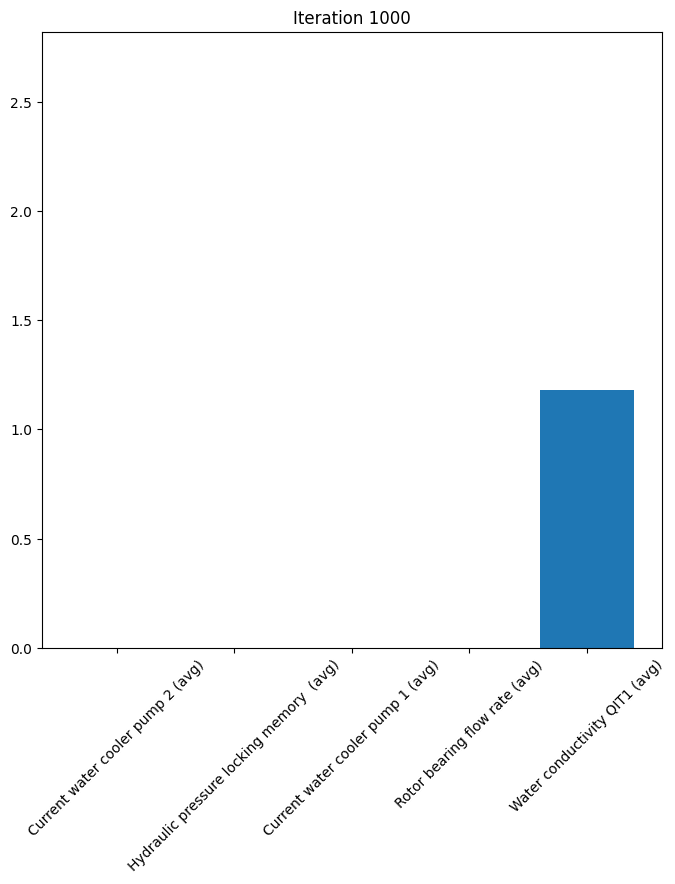

In [25]:
from energy_fault_detector.utils.visualisation import animate_bias
from datetime import datetime

# select a time stamp which you want to inspect
time_stamp = tracked_bias[0].sample().index[0]
top_5_features = list(importances.index[-5:])
# Animate the bias evolution for the features with the top 5 importances in one time stamp
bias_list = [bias.loc[time_stamp] for bias in tracked_bias]
animate_bias(bias_list=bias_list, selected_column_names=top_5_features)

# Plotting the input correction process of ARCANA

2025-10-14 07:43:54,264 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>


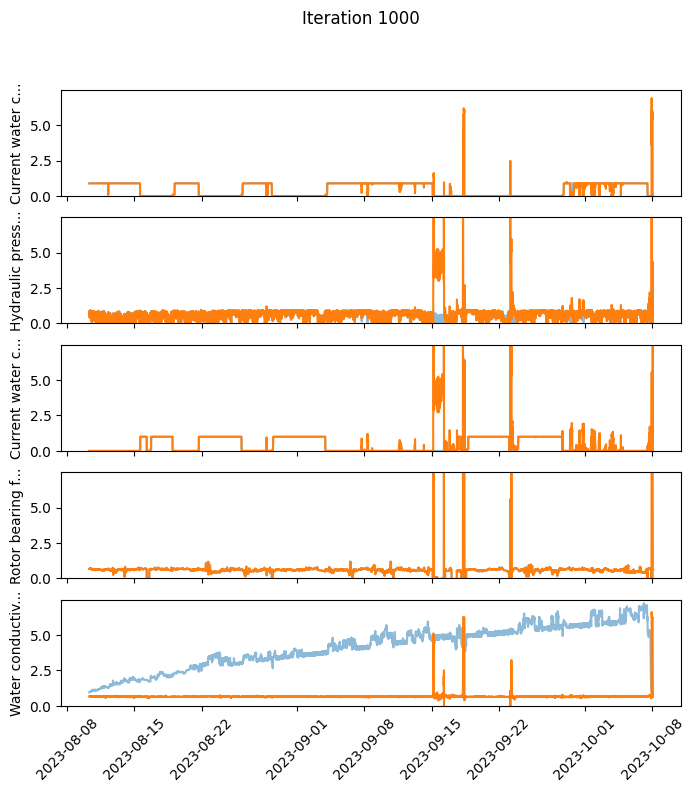

In [26]:
from energy_fault_detector.utils.visualisation import animate_corrected_input
prepped_test_data = model.data_preprocessor.transform(test_sensor_data).loc[event_data.index]
animate_corrected_input(corrected_list=[prepped_test_data + bias for bias in tracked_bias],
                        initial_input=prepped_test_data,
                        selected_column_names=top_5_features)